# Homework 2 - Reid Empey - Econ 213R

For this assignment, here is my gameplan:

1. Read in data.
2. Do some cleaning, filling in missing data, re-scaling, etc.
    * With this dataset, I am going to try running a regression first by omitting the features with missing data, and then run them with imputed values for missing data, and see how much lower I can get the RMSE.
3. Try out a few different models (using cross-validation each time)
    * Normal linear regression
    * Regularized (ridge, lasso, and/or Elastic Nets)
4. After picking the best performing model, tweak with the hyperparameters using either a gridsearch or random search.
5. Pick the best one to submit to Kaggle!

Let's get started!

In [102]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer

%matplotlib inline

The training and testing datasets are given to us by Kaggle, and are easily moved into the notebook. We can then get a look at the first few rows of each one.

In [2]:
train = pd.read_csv("C:/Users/reide/Google Drive/School Documents/Winter 2019/Applied Maching Learning/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("C:/Users/reide/Google Drive/School Documents/Winter 2019/Applied Maching Learning/house-prices-advanced-regression-techniques/test.csv")
# Note that the above test data is for the scoring in the competition, not my own testing. 
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
train.shape


(1460, 81)

In [5]:
test.shape

(1459, 80)

As can be expected, the test group is missing one column, which is the "Sales Price" column that we want to predict for this project. Let's take a look at what different categories we have in this training set.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [7]:
train.get_dtype_counts()

float64     3
int64      35
object     43
dtype: int64

In [8]:
len(train.columns)

81

So, there are 81 different columns, 43 of which are classified as "object", or likely categorical data. Let's see what just two of the numerical data look like in a graph to get a better feel for things.

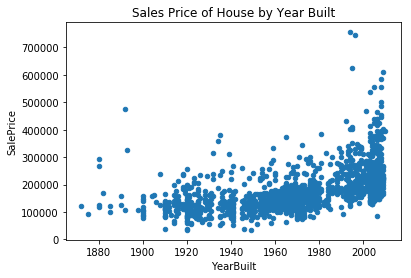

In [9]:
train.plot.scatter("YearBuilt", "SalePrice", title="Sales Price of House by Year Built")

So, in general, we can see a bit of an upward trend with this variable, with newer homes being sold at higher prices. There is a lot of bunched up data, though, so it is difficult to know just from looking at it here.

Now that we've looked at two numerical features, let's look at a categorical feature in more detail. For this, I chose Condition1. The data description labels this feature as, "Proximity to main road or railroad", and Condition2 is if a second is present. Hmm. For curiosity's sake, let's look at the different possibilies for Condition1.

In [10]:
train['Condition1'].unique()

array(['Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA',
       'RRNe'], dtype=object)

Hmm, that's interesting. It appears to show the different kinds of access or road that the property is next to, but I'm not sure what most of those mean. Thankfully, we don't have to really know those things in order for the model to make useful predictions, as long as our model knows what is categorical data.

Before we jump into identifying the categorical data (using one-hot encoding), let's look at how low of a RMSE (root mean squared error) we could get with just the numerical data, first with all missing data removed, and then with imputed values for all missing values except for those with more than 60% of the data missing (see Kaggle post referred to below for where I got that idea from).

In [11]:
train.columns[train.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

Above is a list of all the categories with missing data. Using the `len()` function, we can see how many features have missing data.

In [12]:
len(train.columns[train.isnull().any()])

19

So, we can see that 19 of the 81 features has at least some missing data. By looking at the percentage of missing values in each feature, we can get an idea for how many are missing from each category.

In [13]:
""" Looking at percent missing is a tip I got from https://www.kaggle.com/amrmahmoud123/how-to-clean-your-data, which is
    a tutorial on how to to about cleaning data and handling missing values (imputation) in this data set on Kaggle."""
total = train.isnull().sum().sort_values(ascending=False)
#percent = (train.isnull().sum()*100/train.isnull().count())
#percent

percents = ((1-(train.count()/train.isnull().count()))*100).sort_values(ascending=False)
# Remove all the features with 0% missing values.
percentsDropped = percents[percents!=0]
percentsDropped

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageCond       5.547945
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

By and large, even of the features with missing data, only 4 have over 60% missing values. Let's try some of these out with a normal linear regression model.

To-dos:
No Missing, No Categorical
1. Drop columns with missing data and drop categoricals
2. Train/test split
3. Scale the remaining numerical values
    * Remember to drop and scale the testing data as well as the training data.
    * This means that we need a first train/test split, a grouped dataset that is scaled but ready for CV later, and then to scale the final 'test' file prior to running to submit to Kaggle.

Include Missing (Imputation), No Categorical

Include Missing (Imputation) and Categorical

In [40]:
# Split data into features and target (SalePrice)
target = train.SalePrice
# Drop our target variable and the Id for each entry, since the Id is irrelevant
X_values = train.drop(['SalePrice', 'Id'], axis=1)

# Get the feature names of columns with missing data that need to be dropped
feats_with_missing = percentsDropped.keys()
# Drop the features with missing data
X_no_missing = X_values.drop(feats_with_missing, axis=1)

# Drop categorical variables for now
# X_nm_nc means X values with "no missing" and "no categoricals"
X_nm_nc = X_no_missing.select_dtypes(exclude=['object'])

# Train-Test Split
# Note that I am splitting the data before scaling because including the test data
# in the scaling of the train data actually biases the train data. I won't do
# that in the later CVs because I don't know how to use Pipelines, but I would if I could.
# See https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data
Xnmnc_train, Xnmnc_test, ynmnc_train, ynmnc_test = train_test_split(X_nm_nc, target, test_size=.33, random_state=42)

# Scale our data
scaler = StandardScaler()
scaler.fit(Xnmnc_train)
Xnmnc_scaledtrain = scaler.transform(Xnmnc_train)
Xnmnc_scaledtest = scaler.transform(Xnmnc_test)

C:\Users\reide\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\reide\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
C:\Users\reide\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


In [45]:
# Create a function that will allow us to text different sets of data on the same estimator.
# Adapted from https://www.kaggle.com/dansbecker/handling-missing-values
def score_dataset(X_train, X_test, y_train, y_test):
    model = SGDRegressor(tol=.0001, eta0=.01, random_state=42)
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    return train_rmse, test_rmse

# See what we get for the non-missing, non-categorical data, and check for overfitting
# Create a reusable RMSE checker/printer
def rmse_checker(X_train, X_test, y_train, y_test):
    train_score, test_score = score_dataset(X_train, X_test, y_train, y_test)
    print(f'Training RMSE: {train_score}')
    print(f'Test RMSE: {test_score}')
rmse_checker(Xnmnc_scaledtrain, Xnmnc_scaledtest, ynmnc_train, ynmnc_test)

Training RMSE: 33452.90193918583
Test RMSE: 40074.940358985485


From what it looks like here, we have a bit of an overfitting problem, in that there is a sizable gap between the training and test RMSE. Let's try it again with imputation for missing values in features with under 60% missing.

In [46]:
# Get names of features with more than 60% missing
lots_missing = percentsDropped[percentsDropped>60]
feats_lots_missing = lots_missing.keys()

# Drop the features with over 60% missing data, this is all numerical features that can reliably involve imputation
X_numerical = X_values.drop(feats_lots_missing, axis=1)

# Drop categorical for now
# X_nc means X values with "no categorical" values
X_nc = X_numerical.select_dtypes(exclude=['object'])

# Train-Test Split
# Again, we will scale after the split as previously expalined.
Xnc_train, Xnc_test, ync_train, ync_test = train_test_split(X_nc, target, test_size=.33, random_state=42)

# Imputation (replacing missing variables)
my_imputer = SimpleImputer()
imputed_Xnc_train = Xnc_train.fillna(Xnc_train.mean())
#imputed_Xnc_test = my_imputer.transform(Xnc_test)
imputed_Xnc_test = Xnc_test.fillna(Xnc_test.mean())

# Scale our data
Xnc_scaledtrain = scaler.fit_transform(imputed_Xnc_train)
Xnc_scaledtest = scaler.transform(imputed_Xnc_test)

# Score our dataset
rmse_checker(Xnc_scaledtrain, Xnc_scaledtest, ync_train, ync_test)

Training RMSE: 34949.72931107259
Test RMSE: 45371.800195160155


C:\Users\reide\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\reide\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\reide\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


So, from what we can tell, the test RMSE actually went up, as did the training, so perhaps it didn't make all that much of a difference. Maybe things will improve if we include the categorical variables.

In [47]:
# Train-Test Split
Xall_train, Xall_test, yall_train, yall_test = train_test_split(X_numerical, target, test_size=.33, random_state=42)

#Split Categorical features from numerical ones so we can do imputation, scaling, and get_dummies separately
Xallcat_train = Xall_train.select_dtypes(include=[object])
Xallnum_train = Xall_train.select_dtypes(exclude=[object])
Xallcat_test = Xall_test.select_dtypes(include=[object])
Xallnum_test = Xall_test.select_dtypes(exclude=[object])

# Imputation
imputed_Xallnum_train = Xallnum_train.fillna(Xallnum_train.mean())
imputed_Xallnum_test = Xallnum_test.fillna(Xallnum_test.mean())

# Scale data
Xallnum_scaledtrain = scaler.fit_transform(imputed_Xallnum_train)
Xallnum_scaledtest = scaler.fit_transform(imputed_Xallnum_test)

# Get Dummies
encoded_Xallcat_train = pd.get_dummies(Xallcat_train)
encoded_Xallcat_test = pd.get_dummies(Xallcat_test)

# Rejoin data together
Xall_train = pd.DataFrame(Xallnum_scaledtrain, encoded_Xallcat_train)
Xall_test = pd.DataFrame(Xallnum_scaledtest, encoded_Xallcat_test)

C:\Users\reide\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\reide\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\reide\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\reide\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [48]:
rmse_checker(Xall_train, Xall_test, yall_train, yall_test)

Training RMSE: 34949.72931107259
Test RMSE: 44404.51804885858


Well, we added in the categorical variables, and it didn't seem to do the trick. Let's look at a learning curve to see what's going on more in depth.

In [58]:
model = SGDRegressor(tol=.0001, eta0=.01, random_state=42)
model.fit(Xall_train, yall_train)
train_preds = model.predict(Xall_train)
test_preds = model.predict(Xall_test)
train_rmse = np.sqrt(mean_squared_error(yall_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(yall_test, test_preds))

In [49]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(mean_squared_error))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

C:\Users\reide\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


<module 'matplotlib.pyplot' from 'C:\\Users\\reide\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

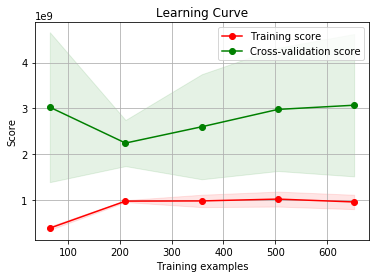

In [59]:
plot_learning_curve(model, "Learning Curve", Xall_train, yall_train)

It looks like things don't ever completely converge. Maybe we can mess with the learning rate to improve the situation.

In [71]:
model = SGDRegressor(max_iter=10000, eta0=.001, random_state=42)
model.fit(Xall_train, yall_train)
train_preds = model.predict(Xall_train)
test_preds = model.predict(Xall_test)
train_rmse = np.sqrt(mean_squared_error(yall_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(yall_test, test_preds))
print("Training RMSE:" + str(train_rmse))
print("Test RMSE:" + str(test_rmse))

C:\Users\reide\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Training RMSE:33041.865694197426
Test RMSE:38952.506804301775


C:\Users\reide\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\reide\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\reide\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinit

<module 'matplotlib.pyplot' from 'C:\\Users\\reide\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

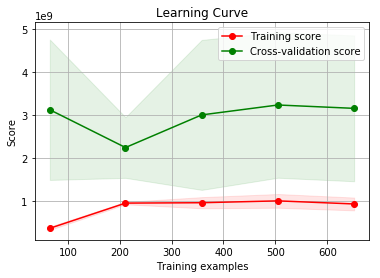

In [72]:
plot_learning_curve(model, "Learning Curve", Xall_train, yall_train)

Well, let's go ahead and try a Ridge Regression to see if we can do better.

In [113]:
#Split Categorical features from numerical ones so we can do imputation, scaling, and get_dummies separately
Xcat = X_numerical.select_dtypes(include=[object])
Xnum = X_numerical.select_dtypes(exclude=[object])

# Imputation
imputed_Xnum = Xnum.fillna(Xnum.mean())

# Scale data
Xnum_scaled = scaler.fit_transform(imputed_Xnum)

# Reconvert to DataFrame
Xnum_scaled = pd.DataFrame(Xnum_scaled, columns=imputed_Xnum.columns)

# Get Dummies
encoded_Xcat = pd.get_dummies(Xcat)

# Rejoin data together
X_train = pd.concat([Xnum_scaled, encoded_Xcat], axis=1, sort=False)

C:\Users\reide\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\reide\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [116]:
ridgeX_train, ridgeX_test, ridgey_train, ridgey_test = train_test_split(X_train, target, test_size=.33, random_state=42)

In [120]:
ridge_model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, target)
ridge_preds = ridge_model.predict(ridgeX_train)
ridge_test_preds = ridge_model.predict(ridgeX_test)
rtrainRMSE = np.sqrt(mean_squared_error(ridgey_train, ridge_preds))
rtestRMSE = np.sqrt(mean_squared_error(ridgey_test, ridge_test_preds))

print("Train MSE: " + str(rtrainRMSE))
print("Test MSE: " + str(rtestRMSE))

Train MSE: 21980.470059076815
Test MSE: 23864.711959924578


Well, looks like it finally got a lot closer! Let's look at the learning curve to see how much it converged.

C:\Users\reide\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


<module 'matplotlib.pyplot' from 'C:\\Users\\reide\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

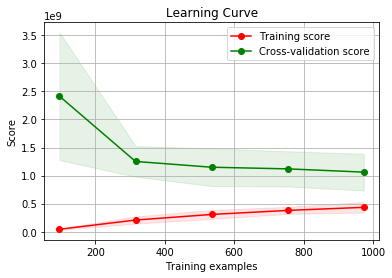

In [119]:
plot_learning_curve(ridge_model, "Learning Curve", X_train, target)

This is much better than before! Now, it still looks like there is quite a bit of overfitting here, but with more data that gap could definitely get smaller. This is the best model I have found, so let's predict the Kaggle test set, and submit it to the competition!

In [125]:
# We have to clean the Kaggle data to get predictions

# Drop numerical categories with not enough data for imputation
test_dropped = X_values.drop(feats_lots_missing, axis=1)

#Split Categorical features from numerical ones so we can do imputation, scaling, and get_dummies separately
Xcat_test = test_dropped.select_dtypes(include=[object])
Xnum_test = test_dropped.select_dtypes(exclude=[object])

# Imputation
imputed_Xnum_test = Xnum_test.fillna(Xnum_test.mean())

# Scale data
Xnum_scaled_test = scaler.fit_transform(imputed_Xnum_test)

# Reconvert to DataFrame
Xnum_scaled_test = pd.DataFrame(Xnum_scaled_test, columns=imputed_Xnum_test.columns)

# Get Dummies
encoded_Xcat_test = pd.get_dummies(Xcat_test)

# Rejoin data together
kaggle_test = pd.concat([Xnum_scaled_test, encoded_Xcat_test], axis=1, sort=False)

C:\Users\reide\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\reide\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [139]:
kaggle_predictions = ridge_model.predict(kaggle_test)
#kaggle_df = kaggle_test['Id']
kaggle_df = pd.DataFrame()
kaggle_df['Id'] = test['Id']
kaggle_df['SalePrice'] = pd.DataFrame(kaggle_predictions)
kaggle_df.to_csv('Reid Empey - Kaggle Housing Submition.csv', index=False)